In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.feature import haar_like_feature
from skimage.transform import integral_image
import mediapipe as mp
import skfuzzy as fuzz
import cv2
from sklearn.model_selection import GridSearchCV

# Load data from the data split with dataSplitAssignment2.ipynb

In [2]:
train_df = pd.read_csv("./data/fer2013_train.csv")
val_df = pd.read_csv("./data/fer2013_validation.csv")
test_df = pd.read_csv("./data/fer2013_test.csv")

In [3]:
emotionDict = {
    0:'0: Angry',
    1:'1: Disgust',
    2:'2: Fear',
    3:'3: Happy',
    4:'4: Sad',
    5:'5: Surprise',
    6:'6: Neutral'
}

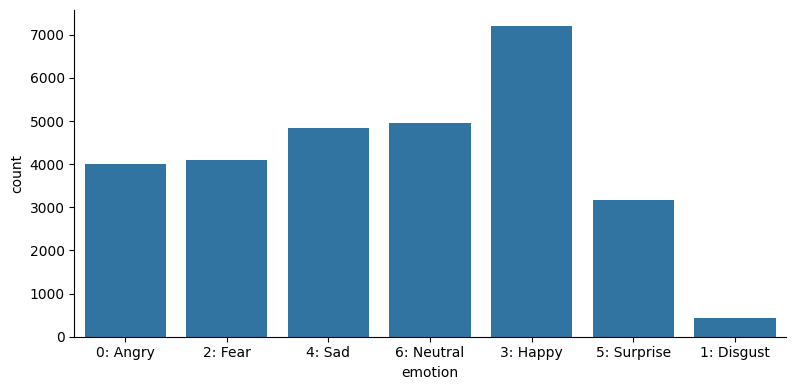

In [4]:
sns.catplot(data=train_df.replace({'emotion': emotionDict}), kind='count', x='emotion', height=4, aspect=2)
plt.show()

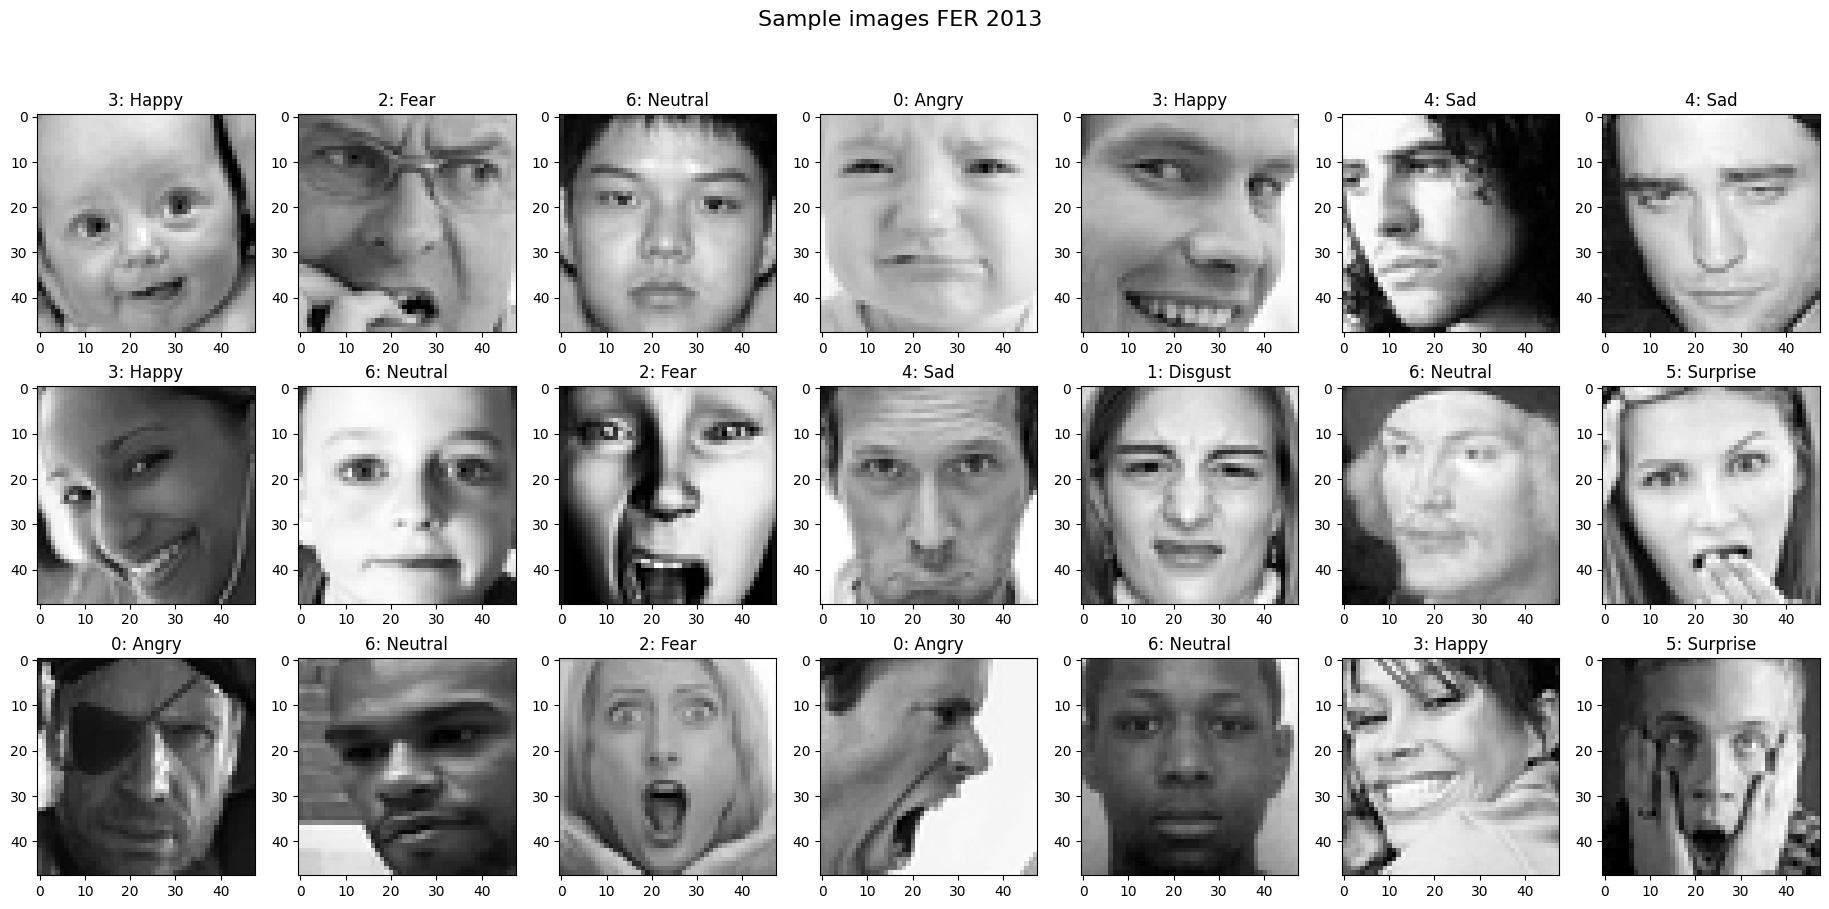

In [5]:
# Now making some plots
random_rows = train_df.sample(n=21, random_state=43)
images = [np.fromstring(pixels, sep=' ').reshape(48, 48) for pixels in random_rows['pixels']]
lbl =  random_rows['emotion'].values

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(23, 10))
fig.suptitle('Sample images FER 2013', fontsize=16)

# Loop through each subplot and customize
for i in range(7):
    for j in range(3):
        ax = axes[j, i]
        ax.imshow(images[j*7+i], cmap="gray") 
        ax.set_title('%s'%(emotionDict[lbl[j*7+i]]))
        #ax.grid(True)
plt.show()


# Feature extraction

In [6]:
train_images = [np.fromstring(pixels, sep=' ').reshape(48, 48) for pixels in train_df['pixels']]
val_images = [np.fromstring(pixels, sep=' ').reshape(48, 48) for pixels in val_df['pixels']]
test_images = [np.fromstring(pixels, sep=' ').reshape(48, 48) for pixels in test_df['pixels']]


In [7]:
X_train = np.array(train_images) / 255.0
y_train = train_df['emotion'].values
X_val   = np.array(val_images) / 255.0
y_val   = val_df['emotion'].values
X_test  = np.array(test_images) / 255.0
y_test  = test_df['emotion'].values

Local binary patterns (LBP)


In [8]:
# Hyperparameters
P = 8   # neighbors
R = 1   # radius

def lbp_features(images, P=8, R=1):
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, P=P, R=R)
        lbp_features.append(lbp.ravel())
    return np.array(lbp_features)

In [9]:
X_train_lbp = lbp_features(X_train, P, R)
X_val_lbp = lbp_features(X_val, P, R)
X_test_lbp = lbp_features(X_test, P, R)

c:\Users\20192913\Anaconda3\envs\base_new\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


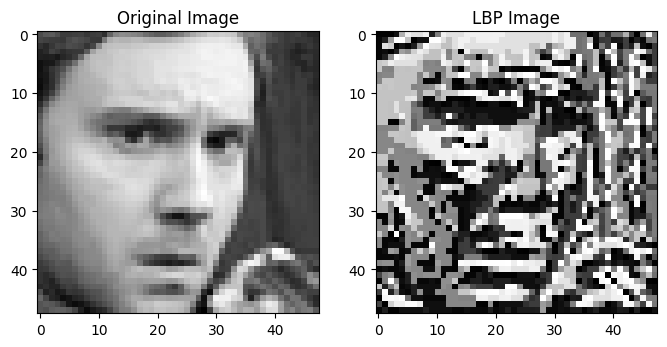

In [10]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(X_train[0], cmap='gray')
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(X_train_lbp[0].reshape(48,48), cmap='gray')
plt.title("LBP Image")
plt.show()


Histogram of orientated gradients (HOG)

In [11]:
hog_params = {'pixels_per_cell': (8,8), 'cells_per_block': (2,2), 'block_norm': 'L2-Hys'}

def hog_features(images, params):
    hog_features = []
    for img in images:
        features = hog(img, visualize=False, **params)
        hog_features.append(features)
    return np.array(hog_features)

In [12]:
X_train_hog = hog_features(X_train, hog_params)
X_val_hog = hog_features(X_val, hog_params)
X_test_hog = hog_features(X_test, hog_params)

Combine LBP and HOG


In [13]:
X_train_combined = np.hstack([X_train_lbp, X_train_hog])
X_val_combined = np.hstack([X_val_lbp, X_val_hog])
X_test_combined = np.hstack([X_test_lbp, X_test_hog])

Raw pixel intensities

In [14]:
X_train_raw = X_train.reshape(X_train.shape[0], -1)/255
X_val_raw = X_val.reshape(X_val.shape[0], -1)/255
X_test_raw = X_test.reshape(X_test.shape[0], -1)/255

PCA

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled   = scaler.transform(X_val_combined)
X_test_scaled  = scaler.transform(X_test_combined)

pca = PCA(n_components=100, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

Eigenfaces

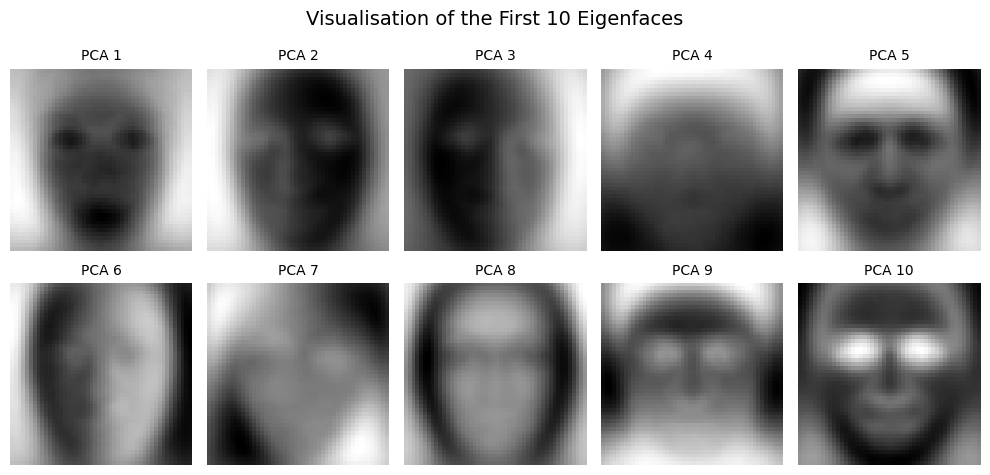

In [16]:
X_train_pca_raw = pca.fit_transform(X_train_raw)
X_val_pca_raw   = pca.transform(X_val_raw)
X_test_pca_raw  = pca.transform(X_test_raw)

eigenfaces = pca.components_.reshape((100, 48, 48))

n_show = 10
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Visualisation of the First 10 Eigenfaces", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"PCA {i+1}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

Haar-like

In [28]:
#def extract_haar_features(images, feature_type=['type-2-x', 'type-2-y']):
#    features = []
#    for img in images:
#        ii = integral_image(img)
#        feats = haar_like_feature(ii, 0, 0, img.shape[0], img.shape[1], feature_type=feature_type)
#        features.append(feats)
#    return np.array(features)

In [29]:
#X_train_haar = extract_haar_features(X_train[:5])  
#X_val_haar   = extract_haar_features(X_val[:5])
#X_test_haar  = extract_haar_features(X_test[:5])

In [30]:
#X_train_pca_haar = pca.fit_transform(X_train_haar)
#X_val_pca_haar = pca.transform(X_val_haar)
#X_test_pca_haar  = pca.transform(X_test_haar)

Facial landmarks

In [21]:
mp_face = mp.solutions.face_mesh

def extract_landmarks(images):
    landmarks = []
    with mp_face.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
        for img in images:
            img_rgb = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_GRAY2RGB)
            result = face_mesh.process(img_rgb)
            if result.multi_face_landmarks:
                points = []
                for lm in result.multi_face_landmarks[0].landmark:
                    points.extend([lm.x, lm.y])
                landmarks.append(points)
            else:
                landmarks.append([0]*468*2)
    return np.array(landmarks)

In [36]:
X_train_landmarks = extract_landmarks(X_train)
X_val_landmarks   = extract_landmarks(X_val)
X_test_landmarks  = extract_landmarks(X_test)

In [32]:
X_train_pca_facial = pca.fit_transform(X_train_landmarks)
X_val_pca_facial = pca.transform(X_val_landmarks)
X_test_pca_facial  = pca.transform(X_test_landmarks)

# Machine leaning models

In [24]:
def train_and_evaluate(clf, X_train, y_train, X_val, y_val, name="Classifier"):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} accuracy: {acc:.4f}")
    return acc

# SVM

Raw pixel intensities

In [ ]:
clf_svm_raw = LinearSVC(max_iter=5000)  # max_iter is voor de snelheid even gedaan, later wel hele set gebruiken
train_and_evaluate(clf_svm_raw, X_train_raw, y_train, X_val_raw, y_val, "Linear SVM")


Linear SVM accuracy: 0.3491


0.34912231819448314

In [ ]:
clf_svm_raw_pca = LinearSVC(max_iter=5000)  # max_iter is voor de snelheid even gedaan, later wel hele set gebruiken
train_and_evaluate(clf_svm_raw_pca, X_train_pca_raw, y_train, X_val_pca_raw, y_val, "Linear SVM")

Linear SVM accuracy: 0.3472


0.3471719141822235

LBP

In [ ]:
clf_svm_lbp = LinearSVC(max_iter=5000)
train_and_evaluate(clf_svm_lbp, X_train_lbp, y_train, X_val_lbp, y_val, "Linear SVM")


Linear SVM accuracy: 0.3182


0.31819448314293675

HOG

In [ ]:
clf_svm_hog = LinearSVC(max_iter=5000)
train_and_evaluate(clf_svm_hog, X_train_hog, y_train, X_val_hog, y_val, "Linear SVM")


Linear SVM accuracy: 0.4400


0.43995541933686266

LBP + HOG

In [ ]:
clf_svm_combined = LinearSVC(max_iter=5000)
train_and_evaluate(clf_svm_combined, X_train_pca, y_train, X_val_pca, y_val, "Linear SVM")


Linear SVM accuracy: 0.4280


0.427974366118696

Raw pixel intensities

In [ ]:
clf_mlp_raw = MLPClassifier(hidden_layer_sizes=(256,), max_iter=100, verbose=True)
train_and_evaluate(clf_mlp_raw, X_train_raw, y_train, X_val_raw, y_val, "MLP")

Iteration 1, loss = 1.82486662
Iteration 2, loss = 1.78868985
Iteration 3, loss = 1.76318375
Iteration 4, loss = 1.74203358
Iteration 5, loss = 1.72405102
Iteration 6, loss = 1.70897462
Iteration 7, loss = 1.69578932
Iteration 8, loss = 1.68397079
Iteration 9, loss = 1.67490427
Iteration 10, loss = 1.66660079
Iteration 11, loss = 1.66144696
Iteration 12, loss = 1.65672097
Iteration 13, loss = 1.65231071
Iteration 14, loss = 1.64770271
Iteration 15, loss = 1.64428597
Iteration 16, loss = 1.64220608
Iteration 17, loss = 1.63872548
Iteration 18, loss = 1.63502860
Iteration 19, loss = 1.63349316
Iteration 20, loss = 1.62999729
Iteration 21, loss = 1.63009715
Iteration 22, loss = 1.62457399
Iteration 23, loss = 1.62341398
Iteration 24, loss = 1.62104807
Iteration 25, loss = 1.61866624
Iteration 26, loss = 1.61914234
Iteration 27, loss = 1.61426681
Iteration 28, loss = 1.61272821
Iteration 29, loss = 1.61086615
Iteration 30, loss = 1.60891145
Iteration 31, loss = 1.60742059
Iteration 32, los

c:\Users\20192913\Anaconda3\envs\base_new\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP accuracy: 0.3993


0.39927556422401783

In [ ]:
clf_mlp_pca_raw = MLPClassifier(hidden_layer_sizes=(256,), max_iter=100, verbose=True)
train_and_evaluate(clf_mlp_pca_raw, X_train_pca_raw, y_train, X_val_pca_raw, y_val, "MLP")

Iteration 1, loss = 1.84549845
Iteration 2, loss = 1.79888750
Iteration 3, loss = 1.78380612
Iteration 4, loss = 1.76389578
Iteration 5, loss = 1.74405737
Iteration 6, loss = 1.72509461
Iteration 7, loss = 1.70846227
Iteration 8, loss = 1.69287745
Iteration 9, loss = 1.67956088
Iteration 10, loss = 1.66867614
Iteration 11, loss = 1.66006051
Iteration 12, loss = 1.65258099
Iteration 13, loss = 1.64684711
Iteration 14, loss = 1.64263461
Iteration 15, loss = 1.63943356
Iteration 16, loss = 1.63713252
Iteration 17, loss = 1.63424745
Iteration 18, loss = 1.63209748
Iteration 19, loss = 1.63027010
Iteration 20, loss = 1.62862535
Iteration 21, loss = 1.62649439
Iteration 22, loss = 1.62588691
Iteration 23, loss = 1.62367239
Iteration 24, loss = 1.62244480
Iteration 25, loss = 1.62099114
Iteration 26, loss = 1.62053439
Iteration 27, loss = 1.61852799
Iteration 28, loss = 1.61743641
Iteration 29, loss = 1.61667507
Iteration 30, loss = 1.61563461
Iteration 31, loss = 1.61463592
Iteration 32, los

c:\Users\20192913\Anaconda3\envs\base_new\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.3959320144887155

LBP

In [ ]:
clf_mlp_lbp = MLPClassifier(hidden_layer_sizes=(256,), max_iter=100, verbose=True)
train_and_evaluate(clf_mlp_lbp, X_train_lbp, y_train, X_val_lbp, y_val, "MLP")

Iteration 1, loss = 7.22691363
Iteration 2, loss = 1.90785342
Iteration 3, loss = 1.88321865
Iteration 4, loss = 1.86486437
Iteration 5, loss = 1.85148092
Iteration 6, loss = 1.84178599
Iteration 7, loss = 1.83475775
Iteration 8, loss = 1.82956086
Iteration 9, loss = 1.82558310
Iteration 10, loss = 1.82251591
Iteration 11, loss = 1.82009391
Iteration 12, loss = 1.81811705
Iteration 13, loss = 1.81651278
Iteration 14, loss = 1.81519936
Iteration 15, loss = 1.81413721
Iteration 16, loss = 1.81323348
Iteration 17, loss = 1.81253464
Iteration 18, loss = 1.81195343
Iteration 19, loss = 1.81139695
Iteration 20, loss = 1.81103826
Iteration 21, loss = 1.81076692
Iteration 22, loss = 1.81049763
Iteration 23, loss = 1.81043093
Iteration 24, loss = 1.81020588
Iteration 25, loss = 1.81006362
Iteration 26, loss = 1.80993811
Iteration 27, loss = 1.80987461
Iteration 28, loss = 1.80979742
Iteration 29, loss = 1.80978335
Iteration 30, loss = 1.80975779
Iteration 31, loss = 1.80972071
Iteration 32, los

0.2490944552800223

HOG

In [ ]:
clf_mlp_hog = MLPClassifier(hidden_layer_sizes=(256,), max_iter=100, verbose=True)
train_and_evaluate(clf_mlp_hog, X_train_hog, y_train, X_val_hog, y_val, "MLP")

Iteration 1, loss = 1.60202645
Iteration 2, loss = 1.48422302
Iteration 3, loss = 1.44916252
Iteration 4, loss = 1.42895502
Iteration 5, loss = 1.40984432
Iteration 6, loss = 1.39708459
Iteration 7, loss = 1.37438068
Iteration 8, loss = 1.35641564
Iteration 9, loss = 1.34225937
Iteration 10, loss = 1.31837048
Iteration 11, loss = 1.30193594
Iteration 12, loss = 1.27979932
Iteration 13, loss = 1.26055208
Iteration 14, loss = 1.24721811
Iteration 15, loss = 1.22049754
Iteration 16, loss = 1.19971802
Iteration 17, loss = 1.18475535
Iteration 18, loss = 1.16469056
Iteration 19, loss = 1.14839293
Iteration 20, loss = 1.12731852
Iteration 21, loss = 1.11093995
Iteration 22, loss = 1.09178424
Iteration 23, loss = 1.07069874
Iteration 24, loss = 1.05542810
Iteration 25, loss = 1.04139363
Iteration 26, loss = 1.01870144
Iteration 27, loss = 1.00012841
Iteration 28, loss = 0.98367947
Iteration 29, loss = 0.96435788
Iteration 30, loss = 0.95331697
Iteration 31, loss = 0.92945670
Iteration 32, los

c:\Users\20192913\Anaconda3\envs\base_new\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.48286430760657567

LBP + HOG

In [ ]:
clf_mlp_combined = MLPClassifier(hidden_layer_sizes=(256,), max_iter=100, verbose=True)
train_and_evaluate(clf_mlp_combined, X_train_pca, y_train, X_val_pca, y_val, "MLP")

Iteration 1, loss = 1.79509771
Iteration 2, loss = 1.43144741
Iteration 3, loss = 1.31318135
Iteration 4, loss = 1.24054522
Iteration 5, loss = 1.18422196
Iteration 6, loss = 1.13488370
Iteration 7, loss = 1.09820619
Iteration 8, loss = 1.06234054
Iteration 9, loss = 1.03114997
Iteration 10, loss = 1.00038895
Iteration 11, loss = 0.97502069
Iteration 12, loss = 0.95085858
Iteration 13, loss = 0.92942708
Iteration 14, loss = 0.90908665
Iteration 15, loss = 0.88535681
Iteration 16, loss = 0.86877180
Iteration 17, loss = 0.85234855
Iteration 18, loss = 0.83655000
Iteration 19, loss = 0.82171448
Iteration 20, loss = 0.80649801
Iteration 21, loss = 0.79571861
Iteration 22, loss = 0.78345643
Iteration 23, loss = 0.76781666
Iteration 24, loss = 0.75421832
Iteration 25, loss = 0.74112922
Iteration 26, loss = 0.73132495
Iteration 27, loss = 0.72552893
Iteration 28, loss = 0.71003854
Iteration 29, loss = 0.70035031
Iteration 30, loss = 0.68981755
Iteration 31, loss = 0.68429055
Iteration 32, los

c:\Users\20192913\Anaconda3\envs\base_new\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.46475341320702146

# Random forest

Raw pixel intensities

In [ ]:
clf_rf_raw = RandomForestClassifier(n_estimators=100, n_jobs=-1)
train_and_evaluate(clf_rf_raw, X_train_raw, y_train, X_val_raw, y_val, "Random Forest")

Random Forest accuracy: 0.4603


0.46029534689328505

In [ ]:
clf_rf_pca_raw = RandomForestClassifier(n_estimators=100, n_jobs=-1)
train_and_evaluate(clf_rf_pca_raw, X_train_pca_raw, y_train, X_val_pca_raw, y_val, "Random Forest")

Random Forest accuracy: 0.4377


0.43772638617999443

LBP

In [ ]:
clf_rf_lbp = RandomForestClassifier(n_estimators=100, n_jobs=-1)
train_and_evaluate(clf_rf_lbp, X_train_lbp, y_train, X_val_lbp, y_val, "Random Forest")

Random Forest accuracy: 0.3653


0.36528280858177764

HOG

In [ ]:
clf_rf_hog = RandomForestClassifier(n_estimators=100, n_jobs=-1)
train_and_evaluate(clf_rf_hog, X_train_hog, y_train, X_val_hog, y_val, "Random Forest")

Random Forest accuracy: 0.4642


0.4641961549178044

LBP + HOG

In [ ]:
clf_rf_combined = RandomForestClassifier(n_estimators=100, n_jobs=-1)
train_and_evaluate(clf_rf_combined, X_train_combined, y_train, X_val_combined, y_val, "Random Forest")

Random Forest accuracy: 0.4338


0.43382557815547507

# Fuzzy systems

In [37]:
n_classes = 7

X_train_c = X_train_landmarks.T
X_val_c   = X_val_landmarks.T

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_train_c, c=n_classes, m=2, error=0.005, maxiter=1000, init=None)

train_labels = np.argmax(u, axis=0)  

u_val, u0_val, d_val, jm_val, p_val, fpc_val = fuzz.cluster.cmeans_predict(X_val_c, cntr, m=2, error=0.005, maxiter=1000)
val_labels = np.argmax(u_val, axis=0)

train_acc = accuracy_score(y_train, train_labels)
val_acc   = accuracy_score(y_val, val_labels)

print("Fuzzy C-Means Training Accuracy:", train_acc)
print("Fuzzy C-Means Validation Accuracy:", val_acc)

Fuzzy C-Means Training Accuracy: 0.13069072416315441
Fuzzy C-Means Validation Accuracy: 0.13290610197826694


In [ ]:
np.random.seed(42) 
subset_indices = np.random.choice(len(X_train), 500, replace=False)

X_train_subset = X_train_hog[subset_indices]
y_train_subset = y_train[subset_indices]

X_train_pca_hog = pca.fit_transform(X_train_subset)
X_val_pca_hog = pca.transform(X_val_hog)
X_test_pca_hog  = pca.transform(X_test_hog)

scaler = StandardScaler()
X_train_scaled_hog = scaler.fit_transform(X_train_pca_hog)
X_val_scaled_hog   = scaler.transform(X_val_pca_hog)
X_test_scaled_hog  = scaler.transform(X_test_pca_hog)

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}

svm_rbf = SVC(kernel='rbf')
grid_search = GridSearchCV(svm_rbf, param_grid, cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train_scaled_hog, y_train_subset)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_svm = grid_search.best_estimator_

y_val_pred = best_svm.predict(X_val_scaled_hog)
y_test_pred = best_svm.predict(X_test_scaled_hog)

val_acc  = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'C': 10, 'gamma': 0.001}
Best cross-validation score: 0.2739581078806243
Validation Accuracy: 0.2767
Test Accuracy:       0.2778
